In [91]:
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime
import re
import random
import json

# 从文件加载 JSON 数据
with open('car_brands_models_systems.json', 'r') as file:
    car_brands_models_systems = json.load(file)

def generate_car_data(data_amount):
    """
    生成汽车数据，包括车型、自动驾驶软件、硬件配置和价格
    """
    cars = {
        'Manufacturer': [],
        'Car Model': [],
        'Autonomous Software': [],
        'Sensors': [],
        'Computing Units': [],
        'Connectivity': [],
        'Power System': [],
        'Braking System': [],
        'Steering System': [],
        'Price': []
    }

    for _ in range(data_amount):
        # 随机选择品牌
        brand = random.choice(list(car_brands_models_systems.keys()))
        # 根据销量随机选择品牌
        brand = random.choices(list(car_brands_models_systems.keys()), 
                       weights=[car_brands_models_systems[brand]['sales'] for brand in car_brands_models_systems])[0]
        # 根据品牌随机选择型号
        model = random.choice(car_brands_models_systems[brand]['models'])
        car_model = f"{brand} {model['name']}"
        
        # 获取对应的自动驾驶系统和硬件配置
        software_system = car_brands_models_systems[brand]['autonomous_system']
        hardware = car_brands_models_systems[brand]['hardware']
        price = model['price']
        
        # 添加到各列
        cars['Car Model'].append(car_model)
        cars['Autonomous Software'].append(software_system)
        cars['Price'].append(price)
        cars['Manufacturer'].append(brand)
        for system, component in hardware.items():
            cars[system].append(component)

    return pd.DataFrame(cars)

def create_combined_dataframe(data_amount):
    """
    生成包含客户信息、汽车信息和保险信息的综合数据框
    """
    # 创建 Faker 实例，指定英文环境
    fake = Faker('en_US')

    # 生成随机英文人名和地址
    random_names = [fake.name() for _ in range(data_amount)]
    random_addresses = [fake.address() for _ in range(data_amount)]

    # 生成最近一年的过去日期和未来日期
    past_dates = [fake.past_date(start_date='-50d') for _ in range(int(data_amount / 2))]
    future_dates = [fake.future_date(end_date='+50d') for _ in range(int(data_amount / 2))]
    fake_dates = past_dates + future_dates

    # 将日期转换为 datetime.datetime 类型
    fake_dates = [datetime.combine(date, datetime.min.time()) for date in fake_dates]

    # 获取今天的日期
    today = datetime.today()

    # 生成随机的车辆识别码 (VIN)
    def generate_vin():
        vin = ''.join(random.choices('ABCDEFGHJKLMNPRSTUVWXYZ0123456789', k=17))
        return vin

    vins = [generate_vin() for _ in range(data_amount)]

    # 生成汽车数据
    car_data_df = generate_car_data(data_amount)
    prices = car_data_df['Price'].values

    # 生成与汽车价格相关的月保费金额，并保留两位小数
    monthly_premiums = np.round(prices * np.random.uniform(0.00075, 0.0008, data_amount), 2) + 80
    # 生成销售渠道
    channels = ['Online', 'Agent', '4S Stores', 'In-Vehicle Infotainment System']
    channels_prob = [0.32,0.12,0.40,0.16]
    policy_channels = [random.choices(channels, channels_prob)[0] for _ in range(data_amount)]
    car_data_df['Policy Channel'] = policy_channels
    # 生成车辆的年份
    current_year = datetime.now().year
    car_years = [random.randint(current_year - 10, current_year) for _ in range(data_amount)]
    car_data_df['Year'] = car_years

    # 生成车辆的里程数
    # 生成车辆的里程数，与年份相匹配
    car_mileages = [random.randint((current_year - year) * 12000, (current_year - year) * 15000) if random.random() < 0.95 else random.randint(0, (current_year - year) * 20000) for year in car_years]
    car_data_df['Mileage'] = car_mileages

    # 生成事故历史，与年份相匹配，使用泊松分布
    accident_histories = [np.random.poisson(lam=max(0.1, (current_year - year) / 10)) for year in car_years]
    car_data_df['Accident History'] = accident_histories
    # 生成车辆所有者和使用者的关系
    owner_user_relationships = [random.choice(['Personal Ownership', 'Company Ownership']) for _ in range(data_amount)]
    car_data_df['Ownership'] = owner_user_relationships

    # 生成车辆的年均行驶里程
    average_annual_mileages = [mileage // (current_year - year + 1) for mileage, year in zip(car_mileages, car_years)]
    car_data_df['Average Annual Mileage'] = average_annual_mileages
    # 生成每年的行驶里程，与年份和总里程相匹配
    annual_mileages = []
    for year, mileage in zip(car_years, car_mileages):
        years_owned = current_year - year + 1
        if years_owned > 0:
            remaining_mileage = mileage
            annual_mileage = []
            for n in range(years_owned, 0, -1):
                if n == 1:
                    annual_mileage.append(remaining_mileage)
                else:
                    avg_mileage = remaining_mileage // n
                    mileage_for_year = random.randint(avg_mileage - avg_mileage // 10, avg_mileage + avg_mileage // 10)
                    annual_mileage.append(mileage_for_year)
                    remaining_mileage -= mileage_for_year
        else:
            annual_mileage = [mileage]
        annual_mileages.append(annual_mileage)
    car_data_df['Annual Mileage'] = annual_mileages
    # 生成维修和保养记录
    maintenance_records = []
    repair_records = []

    for year in car_years:
        # 生成维修记录，使用泊松分布
        repairs = np.random.poisson(lam=max(0.1, (current_year - year) / 5))
        repair_records.append(repairs)

        # 生成保养记录，假设每年保养1-2次
        maintenances = random.randint(1, 2) * (current_year - year)
        maintenance_records.append(maintenances)

    car_data_df['Repair Records'] = repair_records
    car_data_df['Maintenance Records'] = maintenance_records
    # 生成车辆用途
    car_usages = [random.choice(['Personal', 'Commercial', 'Rental']) for _ in range(data_amount)]
    car_data_df['Usage'] = car_usages
    # 生成过往的理赔记录
    claim_records = []
    for _ in range(data_amount):
        # 每辆车的理赔次数，使用泊松分布
        num_claims = np.random.poisson(lam=1.5)
        claims = []
        for _ in range(num_claims):
            # 随机生成理赔日期，确保在车辆年份之后
            claim_date = fake.date_between(start_date=f"-{current_year - random.choice(car_years)}y", end_date="today")
            claim_amount = round(random.uniform(500, 5000), 2)  # 随机生成理赔金额
            claims.append({'date': claim_date, 'amount': claim_amount})
        claim_records.append(claims)

    car_data_df['Claim Records'] = claim_records
    # 添加 "Status" 列
    status_list = []
    for date in fake_dates:
        if date < today:
            status_list.append('Expired')
        elif 0 <= (date - today).days <= 7:
            status_list.append('Expiring in 7 Days')
        else:
            status_list.append('Active')

    # 创建初始 DataFrame
    df = pd.DataFrame({
        'Client': random_names,
        'Address': random_addresses,
        'Expiration Date': fake_dates,
        'Status': status_list,
        'Premium': monthly_premiums,
        'VIN': vins
    })


    # 提取地址中的州信息
    def extract_state(address):
        match = re.search(r'\b[A-Z]{2}\b', address)
        if match:
            return match.group(0)
        return None

    # 添加 "State" 列
    df['State'] = df['Address'].apply(extract_state)

    # 合并 DataFrame
    df = pd.concat([df, car_data_df], axis=1)

    return df

# 生成 1000 条数据
data_amount = 1000
df = create_combined_dataframe(data_amount)
df.to_csv('dataset/data/car_insurance_simulated_data.csv', index=False)

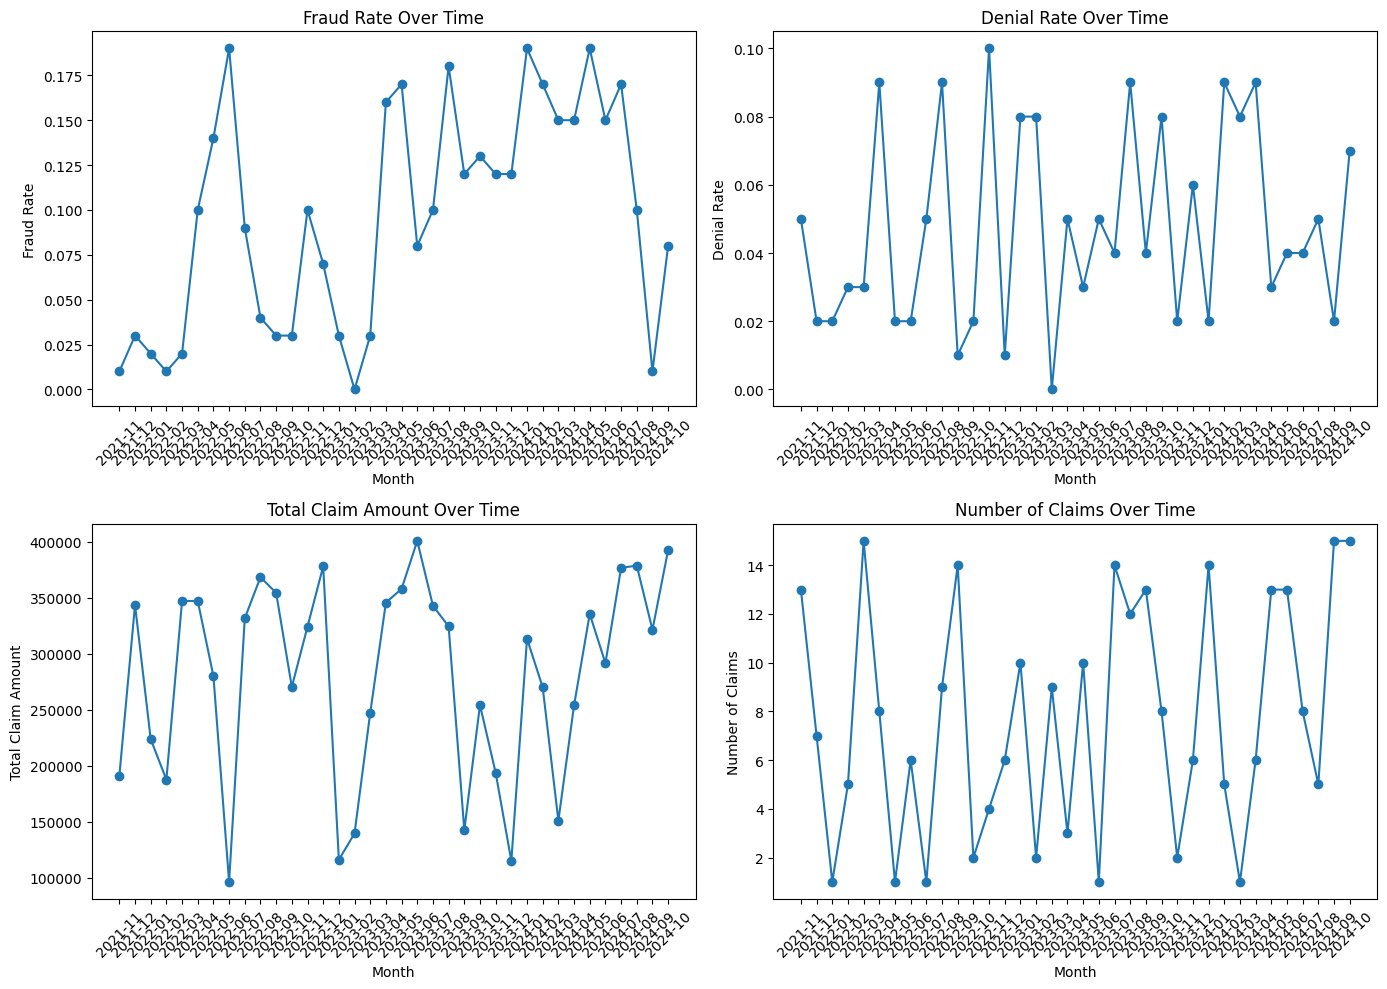

In [75]:
#  Generate Number of Policy Return，total premium, Insured amount, Value of New Business, Policy Renewal Rat# Generate Number of Policy Return, total premium, Insured amount, Value of New Business, Policy Renewal Rate
def generate_insurance_time_series(df, num_months=36):
    # Initialize lists to store time series data
    months = []
    policies_sold_list = []
    total_premium_list = []
    insured_amount_list = []
    value_of_new_business_list = []
    policy_renewal_rate_list = []
    number_of_claims_list = []
    total_claim_amount_list = []
    denial_rate_list = []
    fraud_rate_list = []
    # Generate time series data for the past num_months
    for i in range(num_months):
        # Timestamp for the current month
        month = pd.Timestamp.now() - pd.DateOffset(months=(num_months - i - 1))
        
        # Generate random data for each metric
        # Generate an up-trending number of policies sold
        base_policies_sold = 8000
        policies_sold = int(base_policies_sold + i**0.5 * 50+np.random.uniform(-50, 50))
        
        # Generate an up-trending total premium
        total_premium = np.round(policies_sold *120+policies_sold*np.random.uniform(-3, 3), 2)
        insured_amount = np.round(total_premium *15+total_premium*np.random.uniform(-0.5, 0.5), 2)
        value_of_new_business = np.round(total_premium /policies_sold+i*np.random.uniform(0,1), 2)
        policy_renewal_rate = np.round(np.random.uniform(70, 95), 2)
        number_of_claims = int(np.random.uniform(0, 0.002)*policies_sold)
        total_claim_amount=np.round(np.random.uniform(0.1, 0.4)*total_premium, 2)
        denial_rate=np.round(np.random.uniform(0, 0.1), 2)
        fraud_rate=np.round(np.random.uniform(0, 0.2), 2)
        number_of_claims_list.append(number_of_claims)
        # Append data to lists
        months.append(month.strftime('%Y-%m'))
        policies_sold_list.append(policies_sold)
        total_premium_list.append(total_premium)
        insured_amount_list.append(insured_amount)
        value_of_new_business_list.append(value_of_new_business)
        policy_renewal_rate_list.append(policy_renewal_rate)
        denial_rate_list.append(denial_rate)
        total_claim_amount_list.append(total_claim_amount)
        fraud_rate_list.append(fraud_rate)
    # Create DataFrame from the generated data
    df_time_series = pd.DataFrame({
        'Month': months,
        'Policies Sold': policies_sold_list,
        'Total Premium': total_premium_list,
        'Insured Amount': insured_amount_list,
        'Policy Renewal Rate (%)': policy_renewal_rate_list,
        'Number of Claims': number_of_claims_list,
        'Denial Rate': denial_rate_list,
        'Total Claim Amount': total_claim_amount_list,
        'Fraud Rate': fraud_rate_list
    })

    return df_time_series

# Generate time series data
df_time_series = generate_insurance_time_series(df)

import matplotlib.pyplot as plt


df_time_series.to_csv('dataset/data/overview_4pics.csv', index=False)

# Plot the four series
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Policies Sold
axs[1, 1].plot(df_time_series['Month'], df_time_series['Number of Claims'], marker='o')
axs[1, 1].set_title('Number of Claims Over Time')
axs[1, 1].set_xlabel('Month')
axs[1, 1].set_ylabel('Number of Claims')
# Plot Claim Frequency
axs[1, 0].plot(df_time_series['Month'], df_time_series['Total Claim Amount'], marker='o')
axs[1, 0].set_title('Total Claim Amount Over Time')
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Total Claim Amount')
# Plot Denial Rate
axs[0, 1].plot(df_time_series['Month'], df_time_series['Denial Rate'], marker='o')
axs[0, 1].set_title('Denial Rate Over Time')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Denial Rate')
# Plot Fraud Rate
axs[0, 0].plot(df_time_series['Month'], df_time_series['Fraud Rate'], marker='o')
axs[0, 0].set_title('Fraud Rate Over Time')
axs[0, 0].set_xlabel('Month')
axs[0, 0].set_ylabel('Fraud Rate')

# Fix the tick_params call
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [92]:
import pandas as pd
import json

# 读取数据
insurance_claim = pd.read_csv('dataset/data/Insurance_Claims.csv')

# 计算需要更改的欺诈案例数量
num_fraud_cases = insurance_claim[insurance_claim['fraud_reported'] == 'Y'].shape[0]
num_to_change = int(num_fraud_cases - 0.1 * insurance_claim.shape[0])

# 随机选择需要更改的欺诈案例索引
indices_to_change = insurance_claim[insurance_claim['fraud_reported'] == 'Y'].sample(num_to_change).index

# 将选定的欺诈案例更改为非欺诈
insurance_claim.loc[indices_to_change, 'fraud_reported'] = 'N'

# 提取欺诈和非欺诈的总索赔金额数据
fraud_claims = insurance_claim[insurance_claim['fraud_reported'] == 'Y']['total_claim_amount'].tolist()
non_fraud_claims = insurance_claim[insurance_claim['fraud_reported'] == 'N']['total_claim_amount'].tolist()

# 将数据转换为 JSON 格式
data = {
    'fraud_claims': fraud_claims,
    'non_fraud_claims': non_fraud_claims
}

# 将数据保存为 JSON 文件
with open('dataset/data/insurance_claims_distribution.json', 'w') as f:
    json.dump(data, f)

In [5]:
import folium
import pandas as pd
import json
import requests

# 加载美国各州人口数据
url = 'https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv'
data = pd.read_csv(url)

# 创建基础地图
m = folium.Map(location=[37.8, -96], zoom_start=4)

# 加载GeoJSON数据
state_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'
response = requests.get(state_geo)
state_geo = response.json()
with open('dataset/data/geo_distribution.json', 'w') as f:
    json.dump(state_geo, f)
